In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torchvision
tf = torchvision.transforms.ToTensor()
from omegaconf import OmegaConf
import yaml
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import PIL

from taming.models.vqgan import EMAVQ

def imshow(img, cmap='gray', axis=True):
  axis = 'on' if axis else 'off'
  plt.imshow(img, cmap=cmap)
  plt.axis(axis)
  plt.show()

### Load Model

In [3]:
# model_name = "sqocremavq_16_240_gray_unfit"
model_name = "2024-09-19T18-49-42_LSDSQ_flattened_224_f16_c16384_d256_EMAVQ"

In [4]:
config_path = list((Path("logs")/ model_name).rglob("*project.yaml"))[0]
config = OmegaConf.load(config_path)

In [5]:
# print(yaml.dump(OmegaConf.to_container(config)))

In [6]:
model = EMAVQ(**config.model.params)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/home/jongmin/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jongmin/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth


/home/jongmin/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading craft model from taming/modules/autoencoder/ocr_perceptual/craft_mlt_25k.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [7]:
ckpt_path = list((Path("logs")/ model_name).rglob("*.ckpt"))[0]
sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
missing, unexpected = model.load_state_dict(sd, strict=False)
model.cuda().eval()
torch.set_grad_enabled(False)

In [18]:
list(model.quantize.embedding.modules())

[EmbeddingEMA()]

In [21]:
model.quantize.embedding.weight.shape

torch.Size([16384, 256])

### Load Image

In [8]:
# img_path_list = list(Path("/home/sake/userdata/latent_score_dataset/string_quartet/segments/beethoven/DPCWO4S8mW8/images/flattened_resampled/240_gray").rglob("*.png"))
img_path_list = list(Path("LSDSQ_flattened_240_gray").rglob("*.png"))

img_path_list[0]

PosixPath('LSDSQ_flattened_240_gray/F9qv9DICZOs:0028:15104.png')

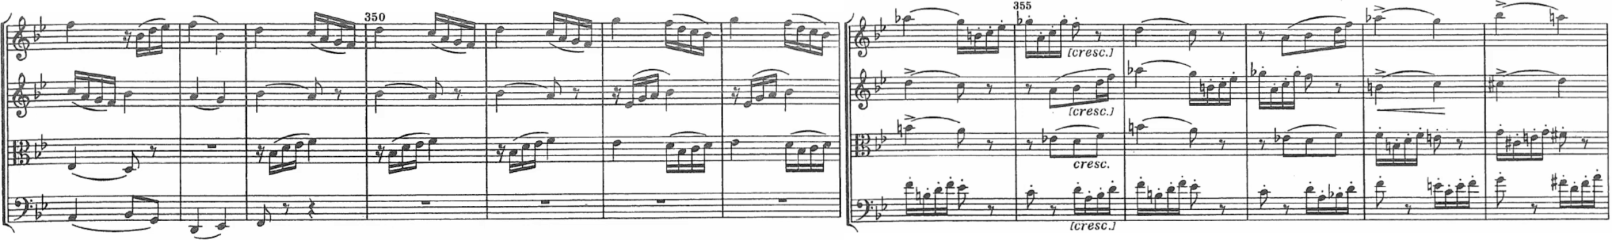

In [9]:
PIL.Image.open(img_path_list[0])

In [10]:
img = tf(PIL.Image.open(img_path_list[0]))
img.shape

torch.Size([1, 240, 1612])

### Encode Image

In [11]:
quant, emb_loss, info = model.encode(img.unsqueeze(0).cuda())

In [12]:
quant.shape, emb_loss, info[2].shape

(torch.Size([1, 256, 15, 100]),
 tensor(0.0135, device='cuda:0'),
 torch.Size([1500]))

In [13]:
info[2].view(quant.shape[0], -1).shape

torch.Size([1, 1500])

In [14]:
info[2].view(quant.shape[0],quant.shape[-2],quant.shape[-1]).shape

torch.Size([1, 15, 100])

In [15]:
info[2].view(quant.shape[0],quant.shape[-2],quant.shape[-1])

tensor([[[ 9653, 12449,  7082,  ..., 12043,  3381,  2936],
         [12204, 10090, 13795,  ..., 10825,  5511, 11410],
         [13569, 12284, 13975,  ...,  4182,  2369,  5653],
         ...,
         [14093, 12655, 13418,  ..., 12998, 12639, 11827],
         [12656, 13477, 10031,  ..., 12552, 13727, 11871],
         [13429,  8594, 11614,  ...,  4546,  6414,  9520]]], device='cuda:0')

### Decode VQ codes

In [16]:
decoded = model.decode_code(info[2].view(quant.shape[0],quant.shape[-2],quant.shape[-1]))

In [17]:
decoded.shape

torch.Size([1, 1, 240, 1600])

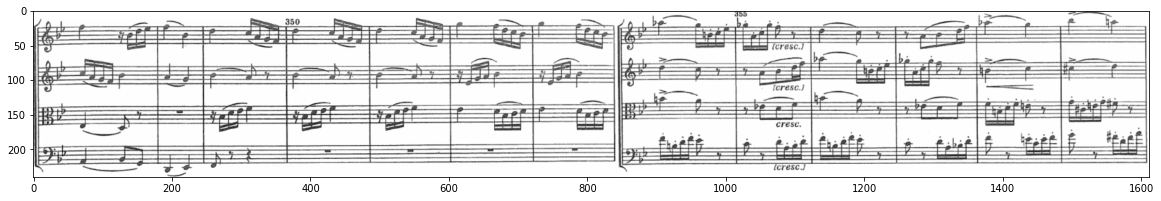

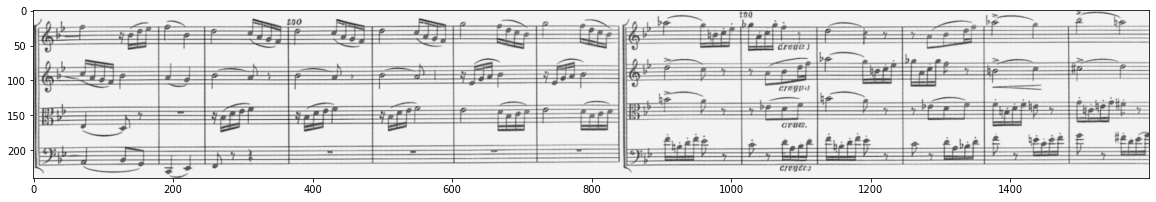

In [18]:
plt.figure(figsize=(20,10), dpi=72)
imshow(img.squeeze())
plt.figure(figsize=(20,10), dpi=72)
imshow(decoded.squeeze().cpu())

### VQ Receptive field analysis

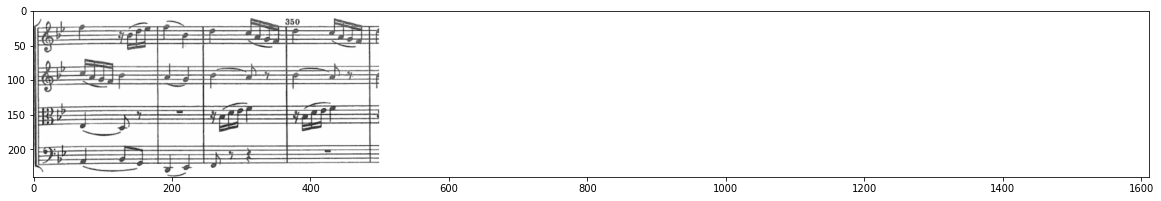

In [20]:
img_copy = img.clone()
img_copy[...,500:] = 1
plt.figure(figsize=(20,10), dpi=72)
imshow(img_copy.squeeze().cpu())

In [21]:
quant, emb_loss, info = model.encode(img_copy.unsqueeze(0).cuda())

In [22]:
decoded = model.decode_code(info[2].view(quant.shape[0],quant.shape[-2],quant.shape[-1]))

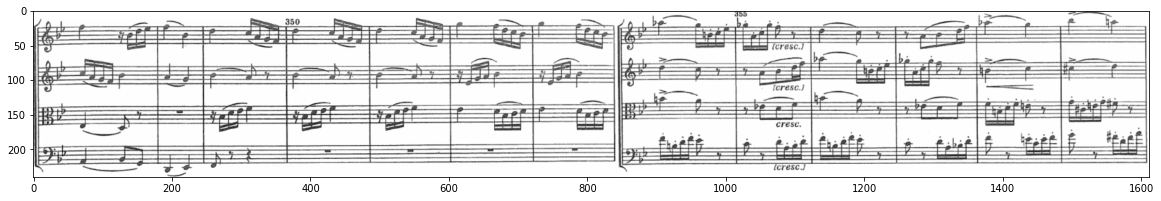

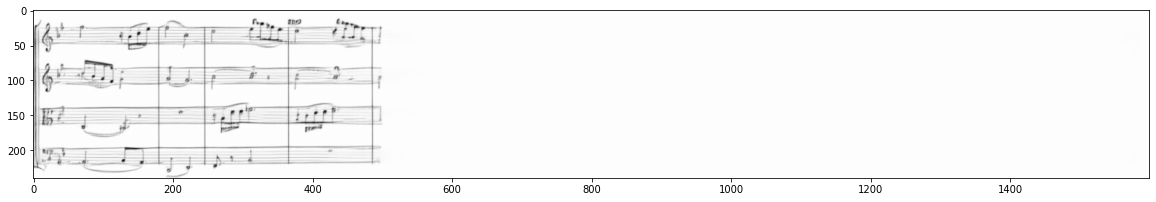

In [23]:
plt.figure(figsize=(20,10), dpi=72)
imshow(img.squeeze())
plt.figure(figsize=(20,10), dpi=72)
imshow(decoded.squeeze().cpu())

### X-axis Iteration (100 pixel as a step)

[...,0:]


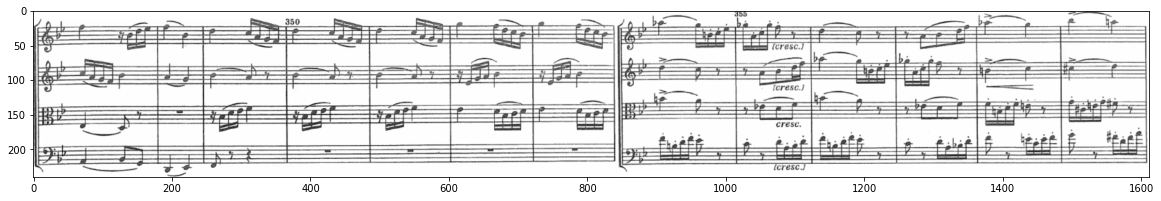

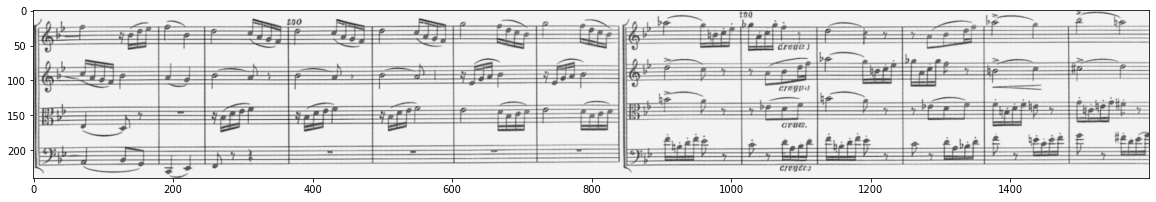

tensor([ 9653, 12204, 13569, 13367,  8706, 13943, 13872, 10501, 11030, 13795,
        13285, 11692, 14093, 12656, 13429], device='cuda:0')


[...,-100:]


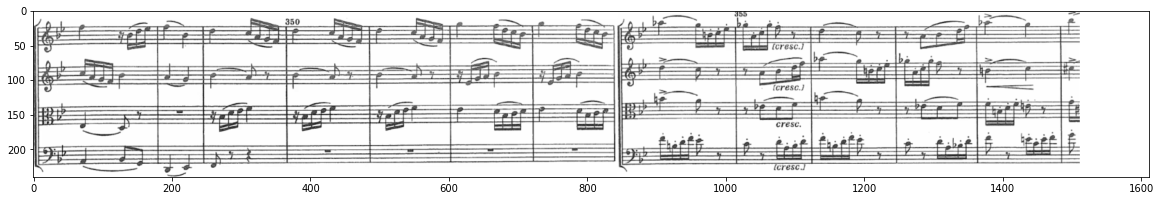

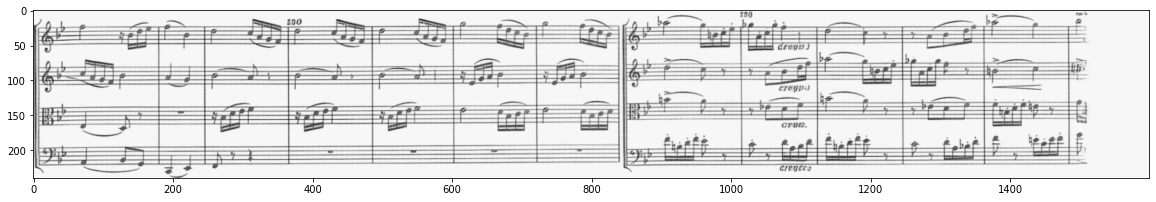

tensor([ 9653, 12204, 13569, 13055,  8706, 13943, 13872, 10501, 11030, 13795,
        13285, 12208, 14093, 12656, 13429], device='cuda:0')


[...,-200:]


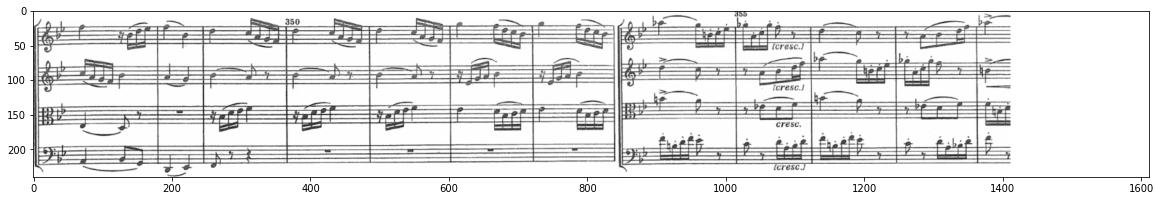

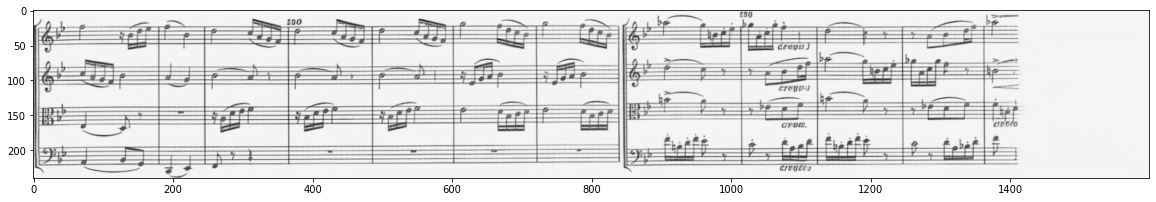

tensor([ 9653, 12204, 13191, 12761,  8706, 13866, 13872, 10501, 11030, 13795,
        13159, 12208, 14093, 12656, 13429], device='cuda:0')


[...,-300:]


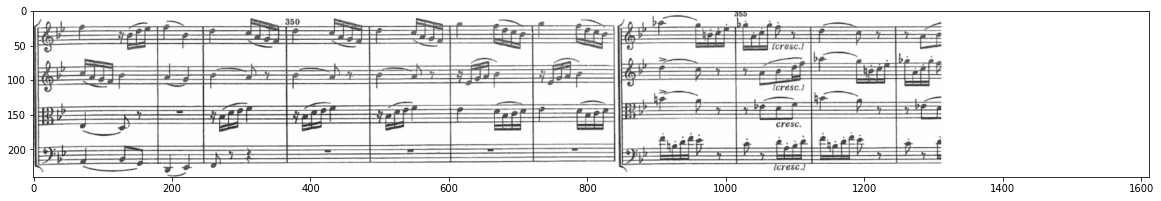

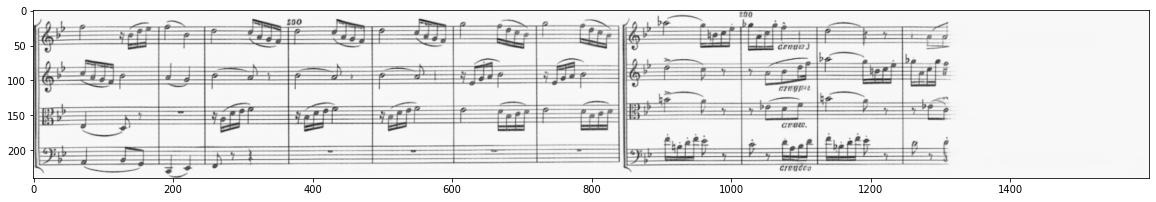

tensor([ 9653, 12204, 13191, 12874,  8706, 13433, 13872, 11188, 11030, 13795,
        13159, 12208, 14093, 12656, 13429], device='cuda:0')


[...,-400:]


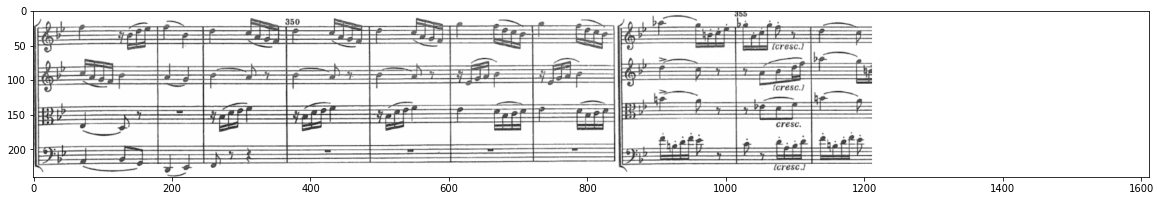

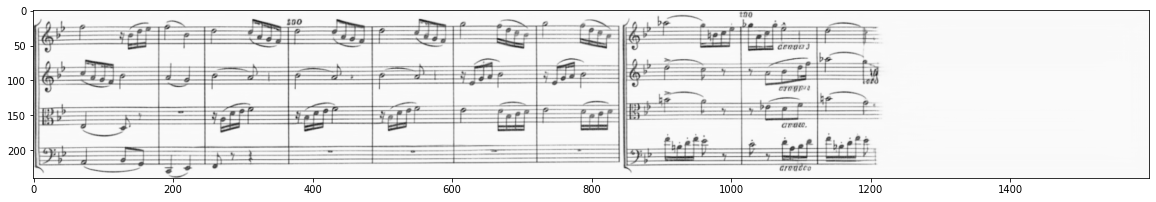

tensor([ 9653, 10567, 13191, 12874,  8706, 13433, 13872, 11188, 11030, 13795,
        13159, 12208, 14093, 12656, 13429], device='cuda:0')


[...,-500:]


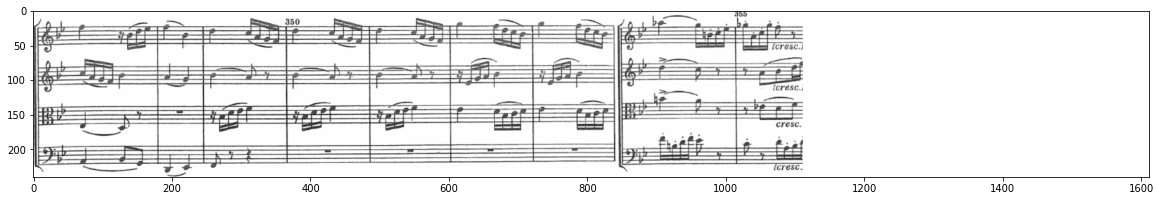

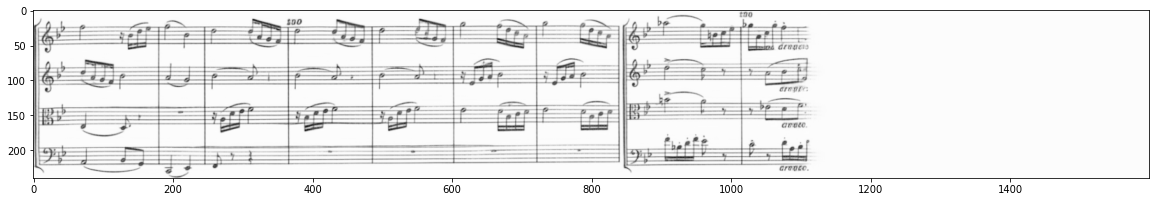

tensor([11241, 10567, 12819, 12874,  8706, 13433, 13872, 11188, 11414, 13795,
        13159, 12208, 14093, 12812, 13429], device='cuda:0')


[...,-600:]


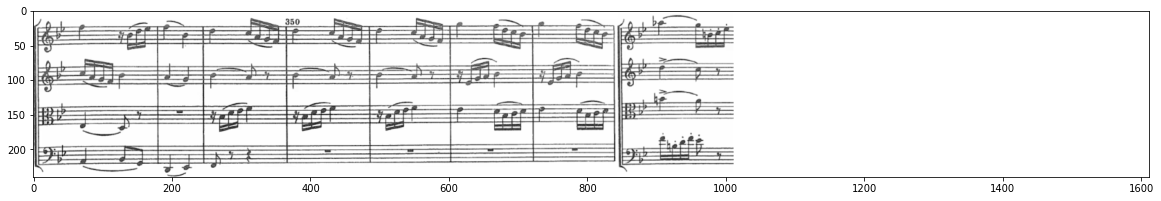

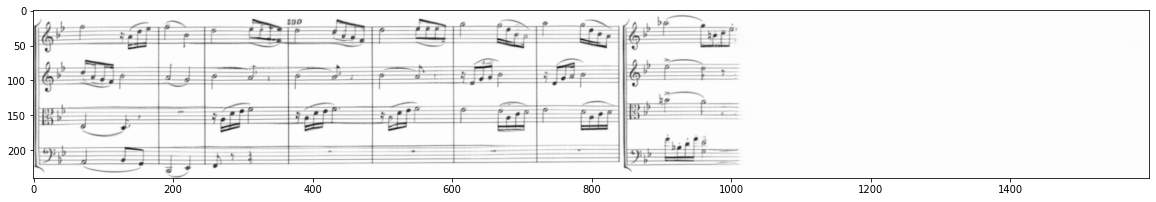

tensor([10500, 10567, 13025, 13242,  9720, 13719, 13872, 11625, 11414, 13356,
        13159,  9881, 14093, 12743, 13429], device='cuda:0')


[...,-700:]


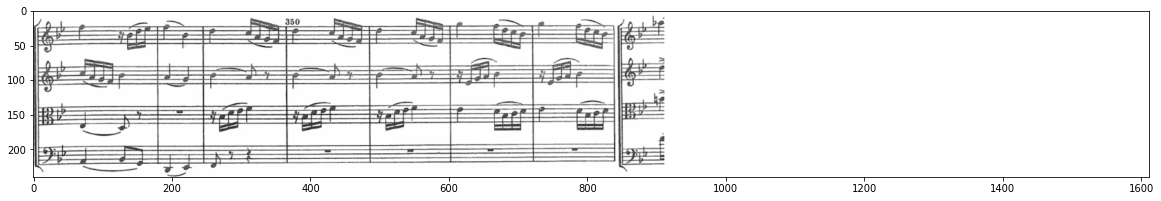

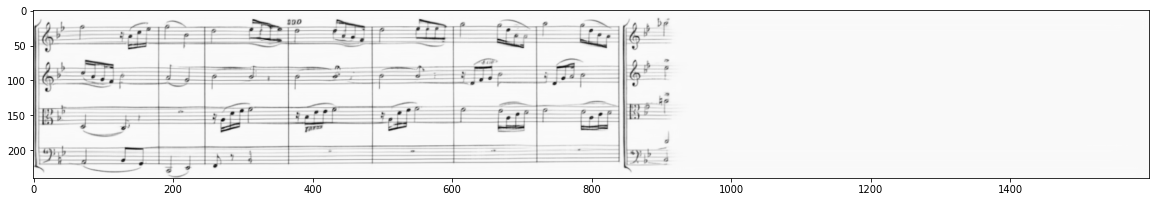

tensor([10500, 10567, 12905, 13242,  9720, 13719, 13285, 11625, 10895, 13356,
        13159,  9881, 14093, 12743, 13429], device='cuda:0')


[...,-800:]


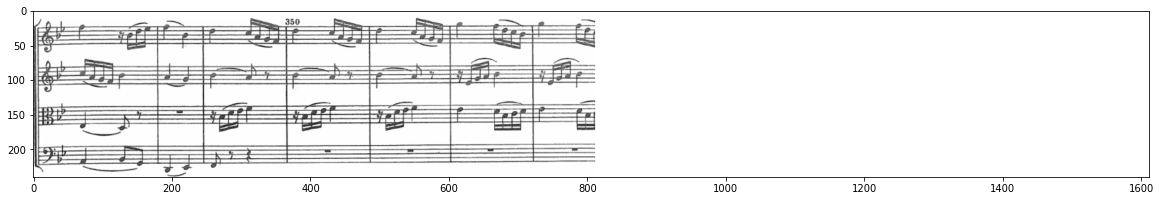

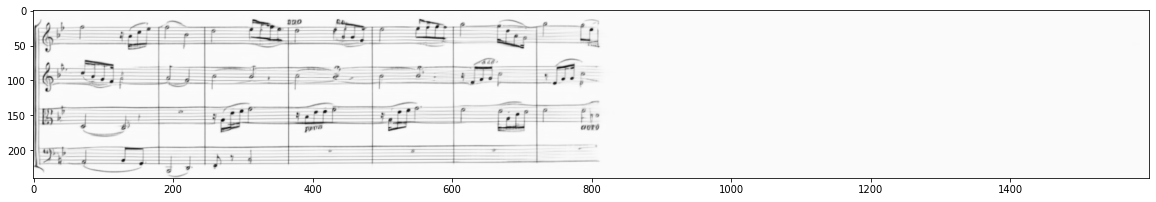

tensor([10500, 10567, 12905, 13242,  9720, 13486, 13198, 11625, 10895, 12876,
        13159,  9881, 14024, 12743, 13429], device='cuda:0')


[...,-900:]


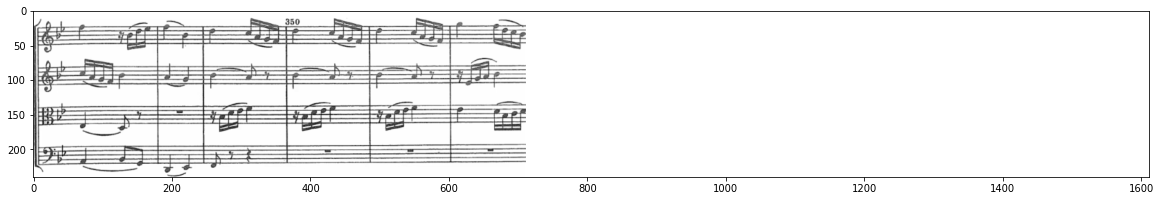

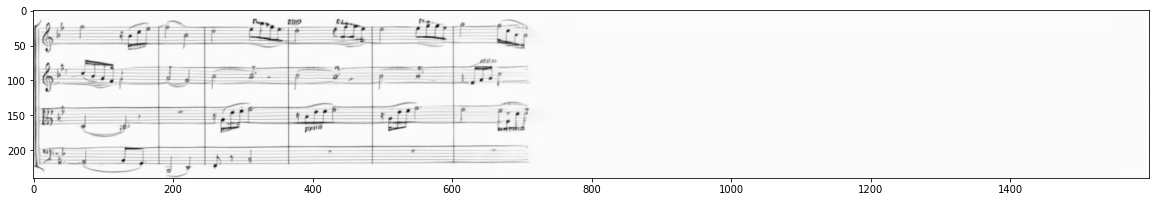

tensor([10500, 10567, 12905, 12284,   579, 13486, 13198, 11625, 10895, 12876,
        12611,  9881, 14024, 10668, 13429], device='cuda:0')


[...,-1000:]


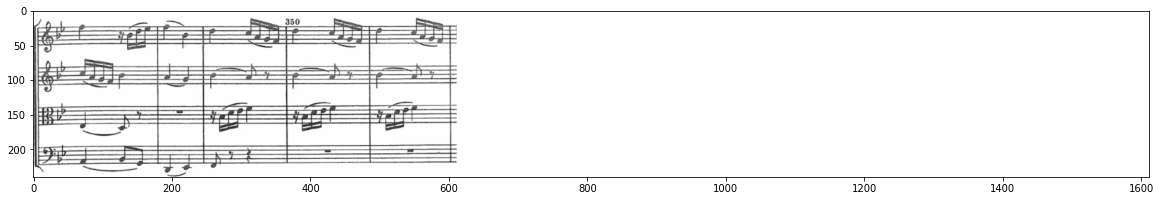

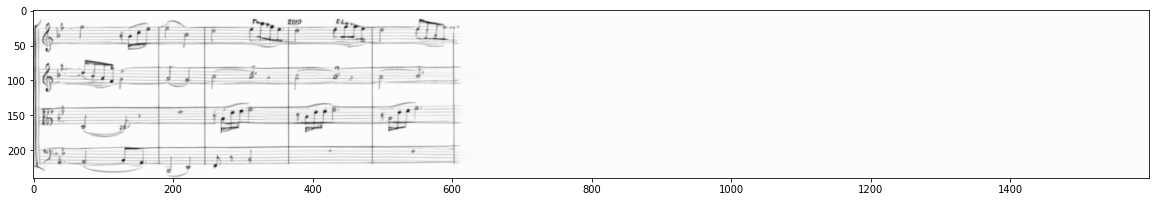

tensor([12108, 10567, 12905, 12284,   579, 13486, 13198, 11625, 12252, 12876,
        12611,  9881, 13879, 10668, 13429], device='cuda:0')


[...,-1100:]


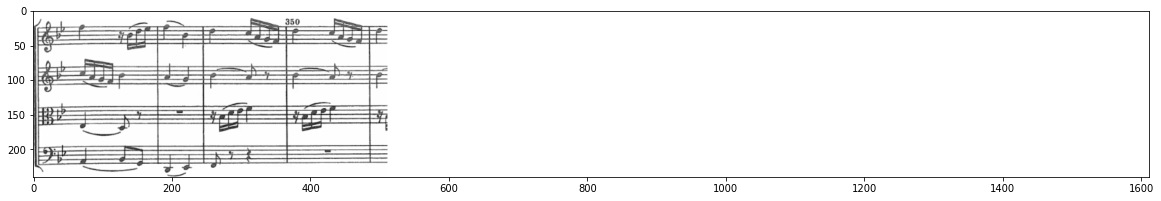

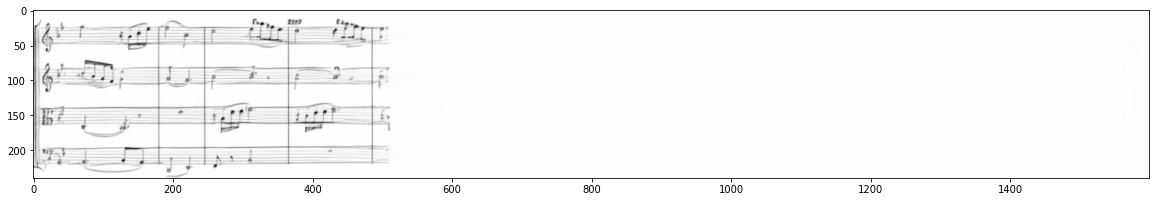

tensor([12108, 10567, 12639, 12284,   579, 13486, 13549, 12703, 12252, 13213,
        12611,  9881, 13577, 11771, 13589], device='cuda:0')


[...,-1200:]


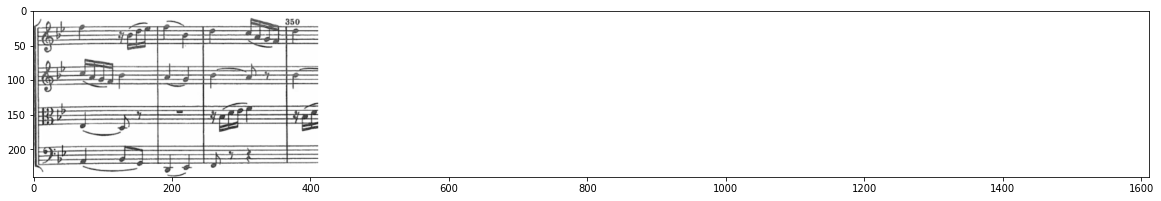

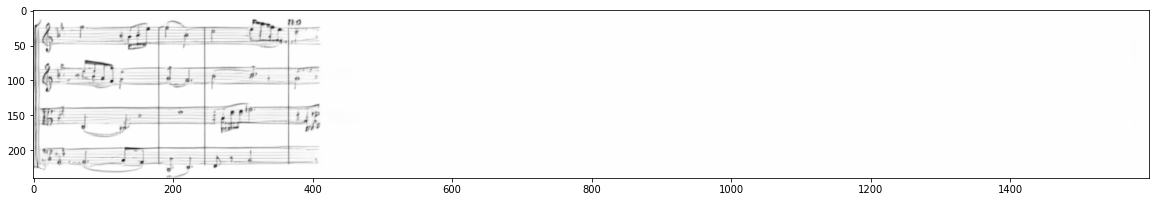

tensor([12666,  8215, 12639, 12284,  1001,  2275, 13549, 12703, 11692, 13213,
        12611,  8938, 13240, 11704, 13589], device='cuda:0')


[...,-1300:]


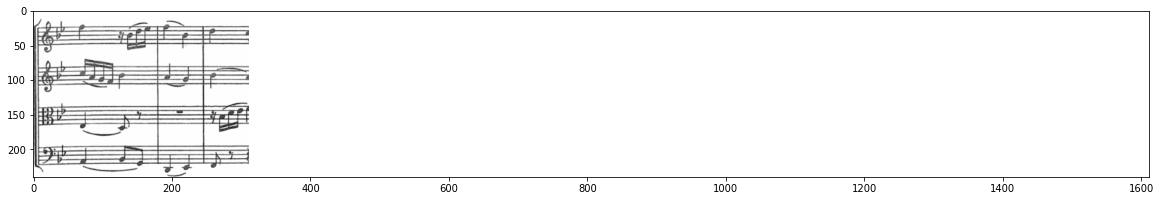

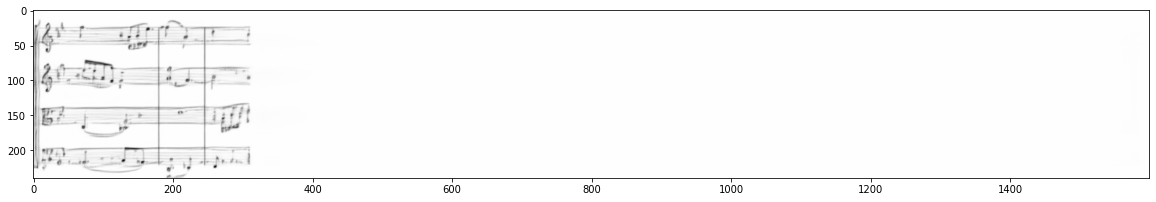

tensor([12082, 10732, 11641, 12165, 10540,  2275, 13031, 11364, 11692, 12382,
        12614,  8938, 12595, 11382, 13793], device='cuda:0')


[...,-1400:]


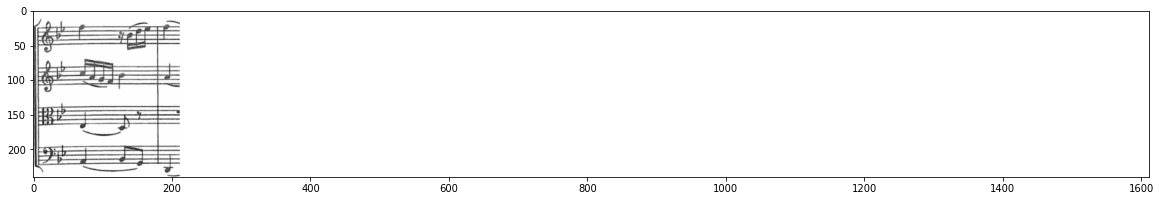

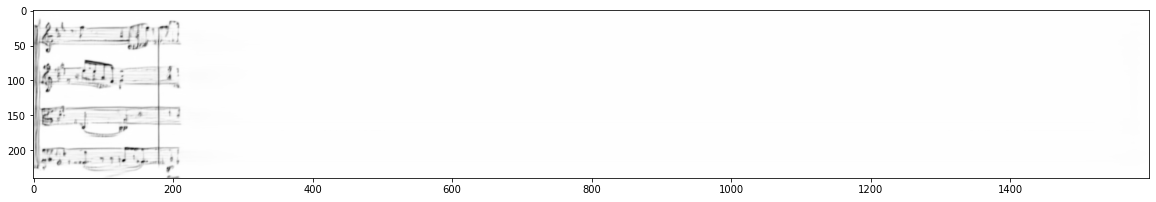

tensor([13069,  8178, 11282, 12525, 10540, 13299, 11818, 12117, 12707, 11164,
        10939, 11120, 12582, 12342, 13626], device='cuda:0')


[...,-1500:]


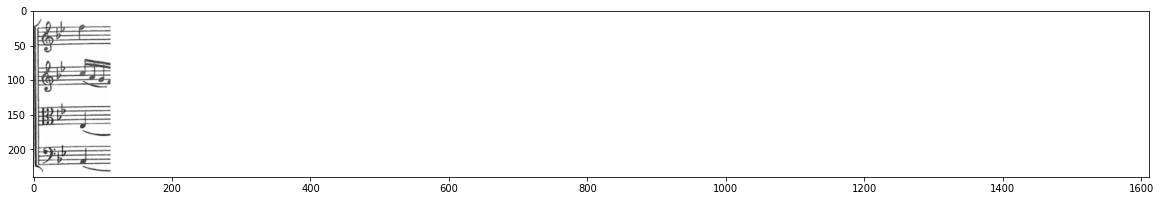

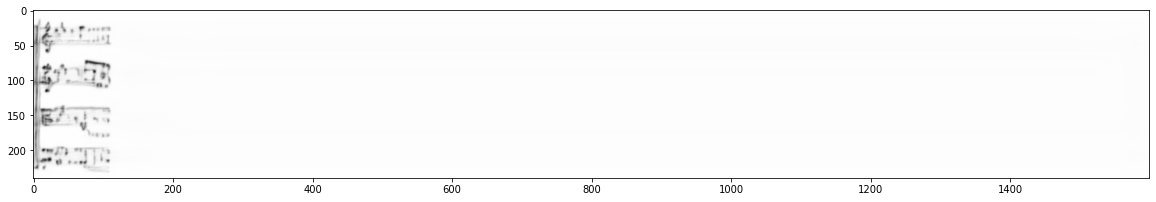

tensor([13347, 10631, 10561, 12262,  7696, 12614, 10003, 11609, 11900,  9001,
         6408, 10621, 11920, 10689, 13757], device='cuda:0')




In [24]:
for i in range(0,img.shape[-1]//100):
  print(f"[...,{- i * 100}:]")
  img_copy = img.clone()
  img_copy[...,img_copy.shape[-1] - i * 100:] = 1
  quant, emb_loss, info = model.encode(img_copy.unsqueeze(0).cuda())
  flattend_out = info[2].view(quant.shape[0],quant.shape[-2],quant.shape[-1])
  decoded = model.decode_code(flattend_out)
  plt.figure(figsize=(20,10), dpi=72)
  imshow(img_copy.squeeze().cpu())
  plt.figure(figsize=(20,10), dpi=72)
  imshow(decoded.squeeze().cpu())
  print(flattend_out[0,:,0])
  print("\n")

### Y-axis Iteration (16 pixel as a step)

[:,0:]


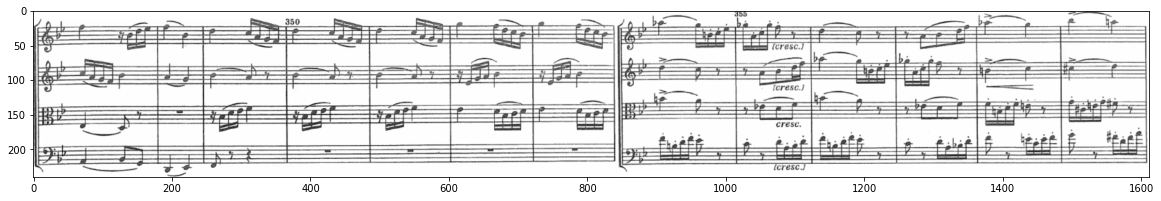

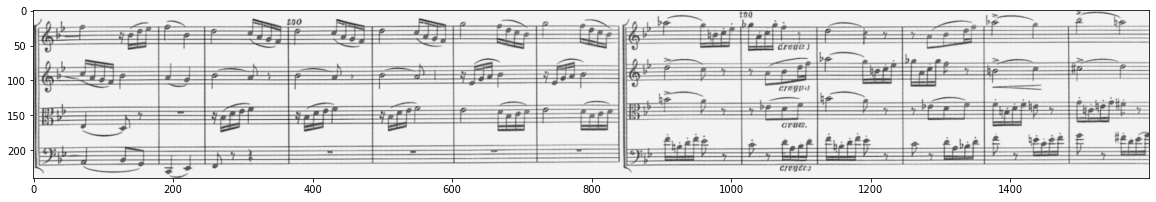

tensor([ 9653, 12449,  7082,  2933,  6039,  2324,  1990,  2845,   525, 10028,
         7462,   839, 13406,  5358,  1289,  3368,  2236,  2845,  1380, 10069,
         8582,  2623,  6770,   930,  6911,   956,   997, 12487,  6285,  4355,
         1911,   441,  1242,  1289,   137,  5908,  5846,   956, 11083,  1639,
         1039,  1230, 13761,  9326,  1841,  4475,  9497,   853,  3913, 13646,
        12399,  2026,  2642, 13542,  7654,  8367, 10653, 14084, 13735, 13653,
          581,   702,  7864,  5169,  5132,   647, 12654,  8761,   917,  1886,
         2120,   853,  9483,  6963,  1009,  1289,  1574,  2120,  2324,  1886,
         2525,  1574, 10132, 11302,  2003, 13909, 12768, 14074, 14156, 10586,
         3447,  1077,   575,  5020, 12629,   277,  9339, 12043,  3381,  2936],
       device='cuda:0')


[:,-16:]


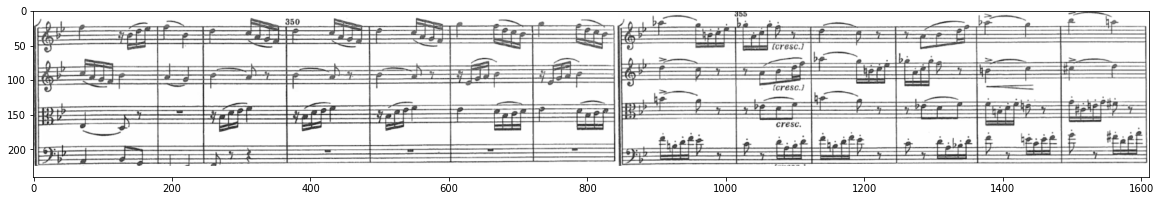

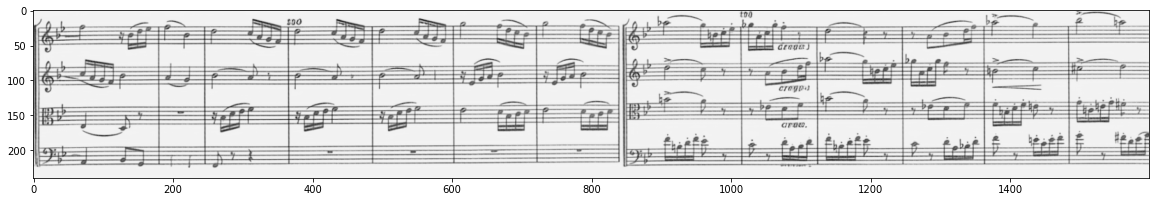

tensor([ 9653, 12449,  7082,  2933,  6039,  2324,  1990,  2845,   525, 10028,
         7462,   839, 13406,  5358,  1289,  3368,  2236,  2845,  1380,  9899,
         8582,  2623,    26,   930,  6911,   956,   997, 12487,  6285,  4355,
         1911,   441,  1242,  1289,   137,  5908,  5846,   956, 11083,  1639,
         1039,  1230, 13761,  9326,  1841,  4475,  9497,   853,  3913, 13646,
        12399,  2948,  2642, 13542,  7654, 10147, 10653, 14084, 13735, 13653,
          581,   702,  7864,  1782,  5132,   647, 12723,  8761,   917,  1886,
         2120,   853,  9699,  6963,  1009,  7028,  1574,  2120,  2324,  2966,
         2525,  1574, 10132, 11302,  2164, 13909, 12768, 14074, 14156, 10586,
         3447,  1077,  7958,  5020, 12629,   277,  9339, 12043,  3381,  2936],
       device='cuda:0')


[:,-32:]


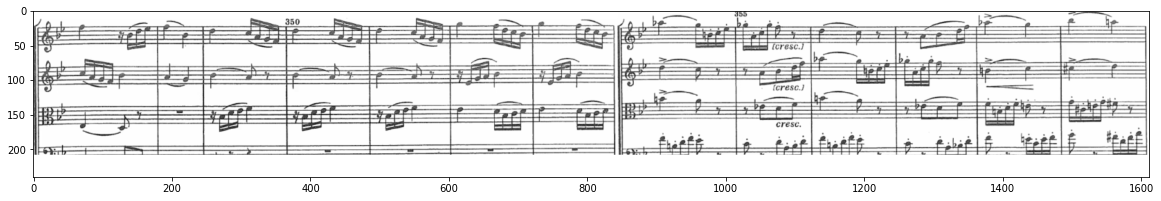

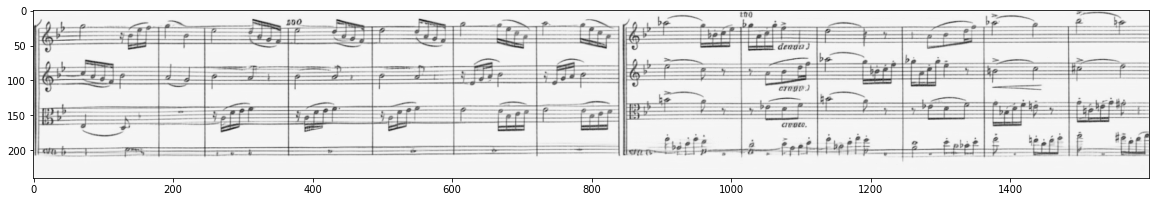

tensor([ 9653, 12449,  7082,  2475,  6766,  3811,  3074,  4743,  1242,  5167,
        10550,  1811, 13406,  6398,  7028,  4504,  2966,  4793,  4654,  9419,
         8582,  2623,    26,   930,  6911,  1611,  3280, 12487,  6285,  3818,
         2043,  1039,  2936,  1934,   137,  5908,  5728,   839, 11083,  1639,
         1845,   538, 13761,  9326,  1841,  4575,  8463,  1845,  3913, 13937,
        12399,  2948,  5201, 13542,  7654, 10004, 11297, 14084, 13698, 13653,
          581,  1077,  7864,  1782,  5132,   647, 12723,  9605,  1289,  2724,
         2209,   853,  9999,  7683,  1671,  7028,  1886,  2120,  4355,  3380,
         1410,  1499, 10132, 11302,  2164, 13735, 12768, 14013, 14208, 10254,
         3447,   853,  7958,  5020, 12886,   277,  7247,  9179,  5602,  2936],
       device='cuda:0')


[:,-48:]


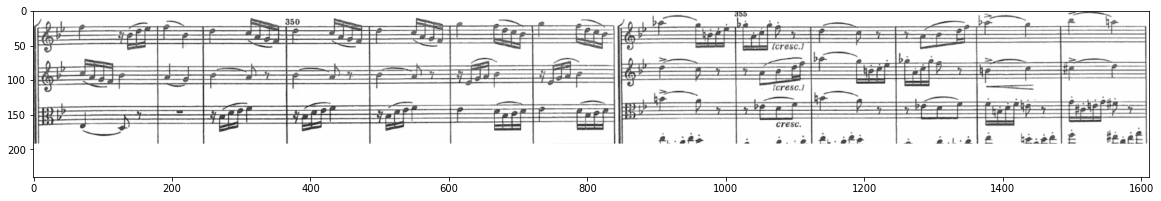

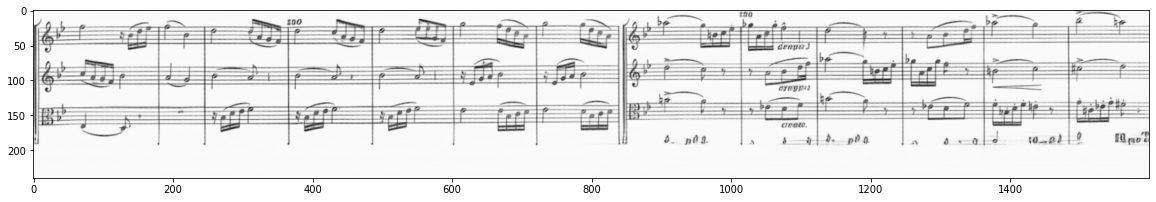

tensor([ 9653, 12297,  5724,  3811,  7737,  4094,  4743,  3368,  1052,  5167,
        10550,  4336, 13406,  6398,  7028,  4504,  2966,  4504,  1081,  9419,
         5908,  2623,    26,   930,  6911,  1811,  3280, 12721,  6285,  3866,
         2043,  1039,  2936,  7028,   137,  5908,  6819,  1811, 11083,  1671,
         1845,  4127, 13950,  8974,  1841,  3468, 10192,  1845,  3913, 13937,
        12399,  2948,  1527, 13601,  3692, 10521, 11297, 14084, 13698, 13653,
          581,  1077,  2288,  3314,  5132,   393, 12617,  9605,  1289,  2724,
         2209,  1845,  9999,  7683,  2120,  3307,  2456,  2209,  2670,  2940,
         1410,  1499, 10132, 11302,  2164, 13735, 12768, 14013, 14125, 10254,
         3248,   853,  4751,  8948, 12886,  2495,  7247,  9179,  5602,  2724],
       device='cuda:0')


[:,-64:]


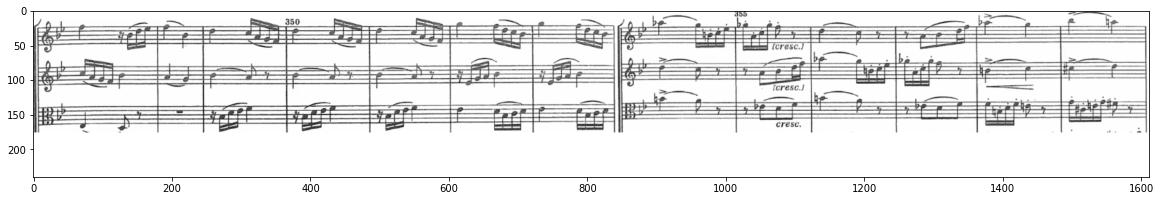

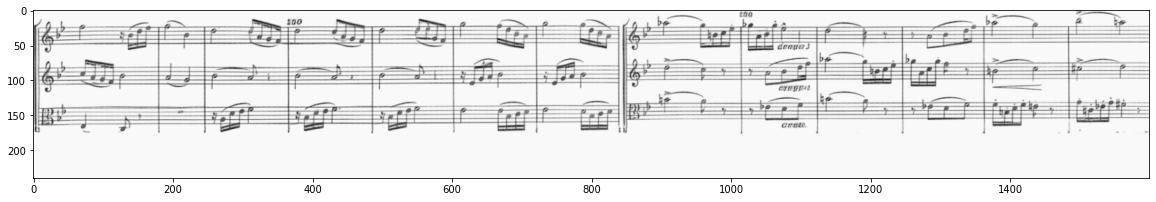

tensor([ 9653, 12297,  5724,  3811,  7737,  4094,  4743,  5530,  1052,  5167,
        10550,  4336, 13406,  6398,  7028,  4504,  2966,  4504,  1081,  9419,
         5908,  2623,  1789,   930,  6108,  1811,  3280, 12721,  6285,  3866,
         2043,  1845,  2936,  7028,   137,  5908,  5159,  4336, 11950,  1671,
          624,  4127, 13950,  8974,  2565,  3468, 10192,  1845,  3913, 13937,
        12399,  2948,  1527, 13601,  3692, 10521, 11297, 14084, 13698, 13653,
          581,  1077,  2288,  3314,  5132,   393, 12617,  9605,  1289,  2724,
         2724,  1699,  9999,  7683,  2120,  3307,  2456,  2209,  3380,  2346,
         1410,  1499, 10132, 11302,  2164, 13735, 12768, 14013, 14125, 10254,
         3248,  1699,  4751,  8948, 12629,  2216,  7247,  9179,  5602,  2724],
       device='cuda:0')


[:,-80:]


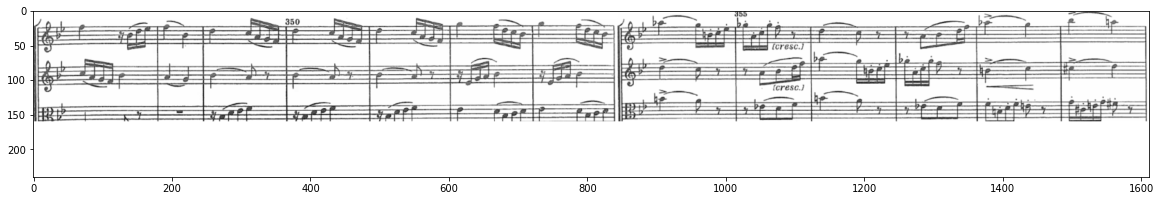

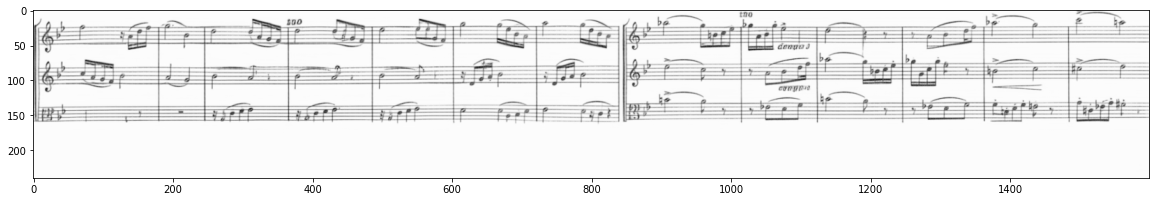

tensor([11241, 12297,  5724,  3811,  7737,  4094,  4743,  4504,  1611,  5167,
        11614,  4336, 13065,  6398,  7028,  3524,  2966,  4504,  1081,  9269,
         5908,  5790,  1789,   930,  6108,  1811,  3280, 12721,  4363,  3866,
         2043,  1845,  2936,  7028,  7629,  5908,  5159,  4336, 11950,  1671,
          624,  4127, 14003,  8974,  2565,  5446, 10192,  1845,   756, 13937,
        12399,  2948,  1527, 13601,  3692, 10521, 11297, 14084, 13684, 13679,
          581,  1077,  2288,  3314,  5132,   393, 12617,  9605,  1911,  2425,
         2724,  1699,  9999,  7683,  2120,  3307,  2456,  2209,  3380,  2346,
         1410,  1499, 10132, 11302,  2164, 13735, 12768, 14013, 14125, 10254,
         3718,  1699,   217,  8948, 12629,  2216,  7247,  9179,  5602,  2425],
       device='cuda:0')


[:,-96:]


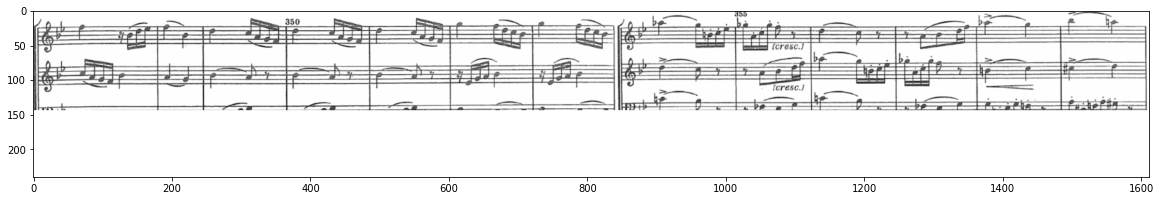

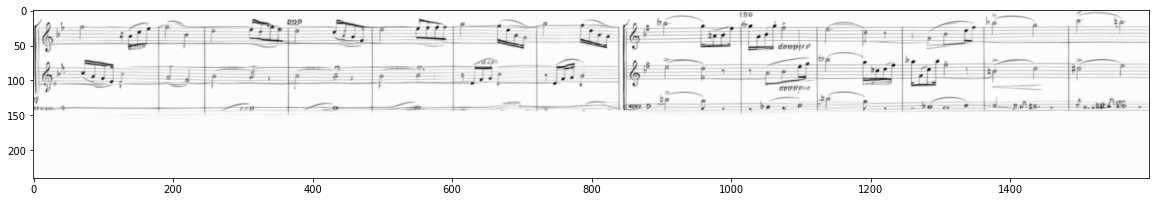

tensor([11241, 12297,  9160,  2324,  7800,  3818,  5530,  4504,  1811,  9486,
        11614,  1601, 13065,  6376,  3307,  3644,  2514,  4504,  1081,  9269,
         5908,  5790,  1789,   930,  6108,  1896,  3280, 12721,  4363,  3380,
         3858,  1845,  2456,  7028,  7629,  5908,  6819,  4336, 11950,  1671,
          624,  4127, 14003,  7782,  2565,  5446, 10192,   624,   756, 13937,
        12399,  2948,  2557, 13601,  2502, 11027, 10346, 14014, 13684, 13144,
         5573,  1289,  4283,  3314,  5132,   393, 12617, 10974,  1911,   867,
         2425,  1699, 11924,  9199,  2120,  2043,  2346,  2724,  2940,  2346,
          871,  1499, 10132, 10803,  4446, 13668, 12768, 13963, 14219, 11337,
         3516,  1699,   217,  8948, 12629,  2216,  7841,  9952,  4134,  2425],
       device='cuda:0')


[:,-112:]


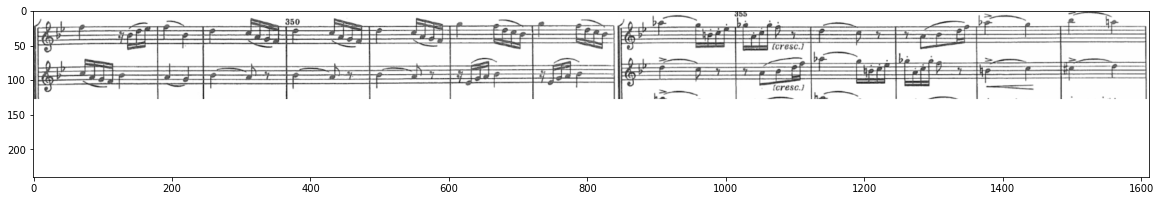

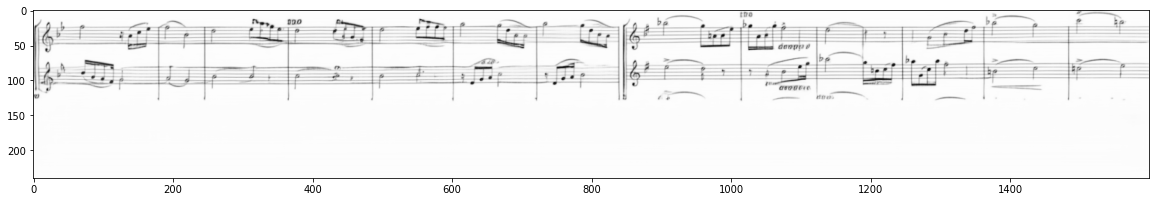

tensor([10500, 12297,  9160,  2236,  7800,  3818,  2744,  3524,  1410,  9777,
        11614,  1415, 13065,  5268,  2367,  2425,  1845,  3524,  2964,  9269,
         5908,  5790,  1789,  5645,  6911,  1601,  1649, 12721,  4363,  3380,
         5673,  1699,  1387,  7028,  7629,  9045,  5159,  1415, 11950,  1671,
         1911,  4127, 14003,  7509,  1575,   538, 10192,  1911,   858, 13937,
        12901,  2948,  2059, 13601,  8484, 11027, 10346, 14014, 13589, 13643,
         5573,  1289,  2288,  3314,  5132,  6371, 12616, 10974,  3307,  3304,
         2425,   839, 11924,  9199,  2120,  2367,  2312,  2425,  2940,  2312,
          859,   725, 10132, 10803,  4446, 13668, 12768, 13637, 14103, 11337,
         1990,  1911,   217,  7716, 12629,  2216,  5506,  9952,  5035,  3304],
       device='cuda:0')


[:,-128:]


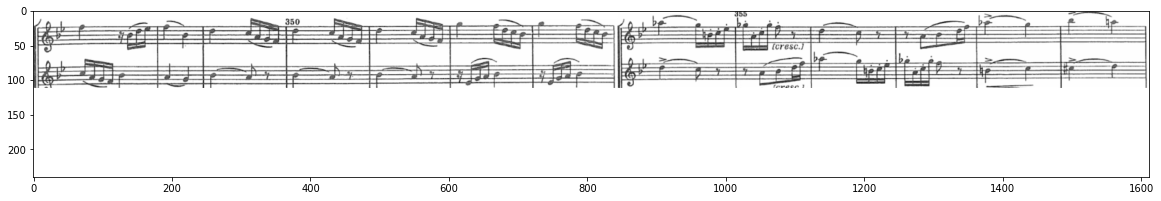

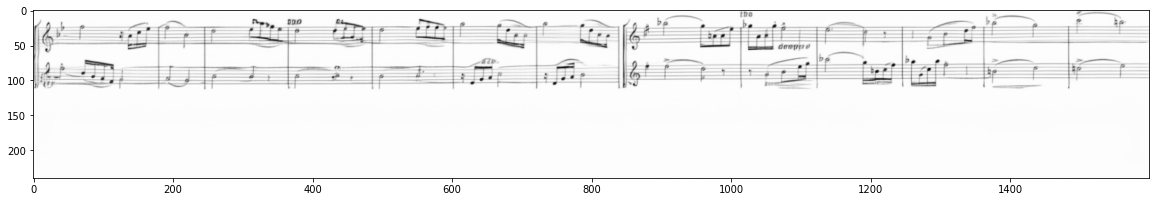

tensor([10500, 12297,  9160,  2236,  7800,  3818,  2744,  3524,  1410,  9777,
        11614,  1415, 13065,  5268,  2367,  2425,  1845,  3524,  2964,  9269,
         5908,  5790,   744,  5645,  6911,  1601,  1649, 11588,  4363,  3380,
         5673,  1699,  1387,  7028,  7629,  9045,  5159,   569, 11950,  1671,
         1911,  4127, 14003,  7509,  1575,   538, 10192,  1911,   858, 13937,
        12901,  1016,  2059, 13601,  8484, 11027, 10346, 14014, 13589, 13643,
         5573,  1289,  2288,  2396,  5132,  6371, 12839, 10974,  3307,  3304,
         2425,   839, 11924,  9199,  1886,  2367,  2312,  2425,  2940,  2312,
          859,   725, 10132, 10803,  4446, 13668, 12768, 13637, 14103, 11337,
         1990,  1911,  1708,  7716, 12629,  2216,  6778,  9952,  5035,  3304],
       device='cuda:0')


[:,-144:]


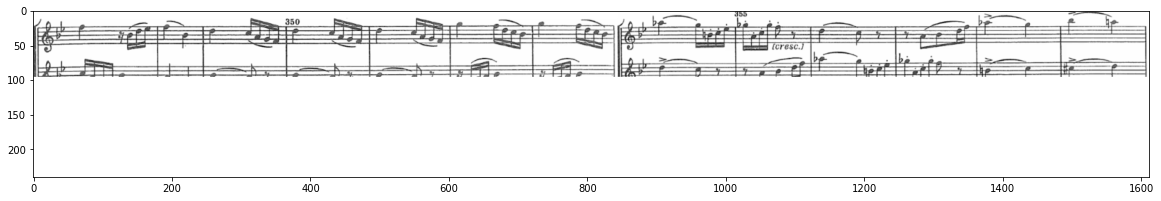

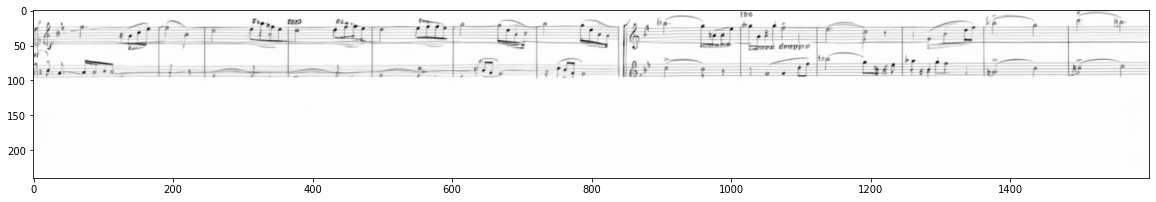

tensor([10500, 12667,  9160,  1380,  7289,  3380,  3524,  2858,  1410,  9777,
        11614,  1825, 12882,  5268,  2367,  3187,  1699,  2858,  2964,  7639,
         9279,  5790,   744,  5645,  6911,  1415,    38, 11966,  6970,  2940,
         5673,  1699,  1545,  7028,  7629,   458,  6819,   569, 11619,  1671,
         1020,  4127, 14003,  7048,   515,  4127, 10259,  2043,   858, 13937,
        12901,  1016,  1636, 13941,  8484, 10092, 11017, 14014, 13793, 13237,
         2381,  1289,   862,  2396,  5132,    25, 12839, 10974,  2043,  1962,
         3304,   839, 11924,  9199,  1886,  2106,   867,  2425,  3714,    59,
          859,   839, 10132, 10803,  4446, 12987, 12411, 13854, 13951, 11337,
         3074,  1911,  1708,  7716, 12843,  1537,  5506,  9952,  5326,  2611],
       device='cuda:0')


[:,-160:]


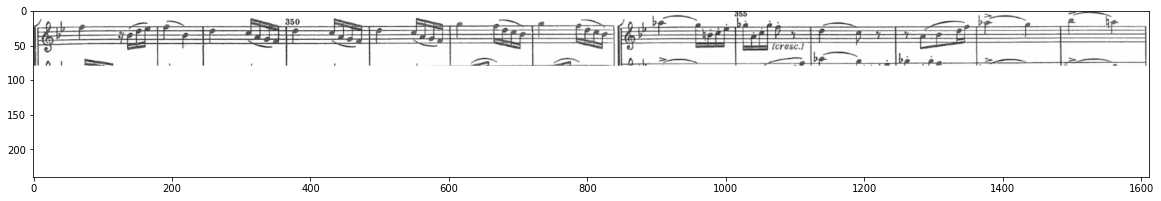

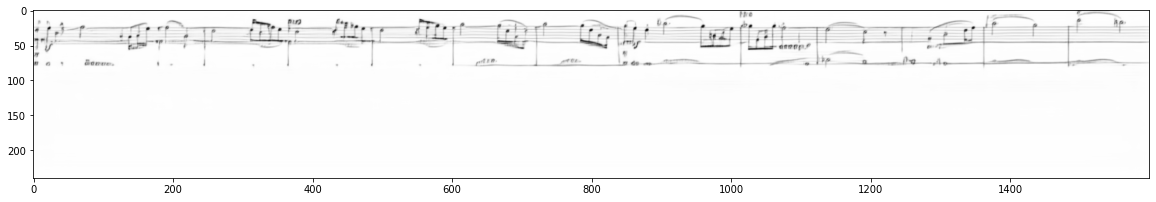

tensor([ 9372, 13238,  4366,  2514,  6863,  5082,  3750,  3750,   871,  7883,
        10687,  1825, 12882,  6376,  5673,  2999,  2312,  3750,  3005,  1080,
         9796,  4753,   744,  5754,  7975,   978,  1335, 11364,  7048,  3714,
         1521,   624,  2611,  3005,  8432,  8658,  7672,  1825, 12789,  2209,
         2807,  5489, 14186,  8852,   643,   939, 10809,  3858,   858, 14000,
        12901,  2113,  1636, 13941,  6293, 11668, 11017, 13951, 13793, 13237,
         4237,  2043,   535,   586,  5132,  2677, 12421, 11191,  2106,  1974,
         2999,  1020, 11825, 10029,  2724,  2388,  3385,  2999,  3385,  4483,
         3015,   839, 10693, 11255,  4249, 11826, 12411, 13570, 13822, 11345,
         4793,   934,  4998,  4085, 12843,  1537,  5506,  9952,  6039,  4525],
       device='cuda:0')


[:,-176:]


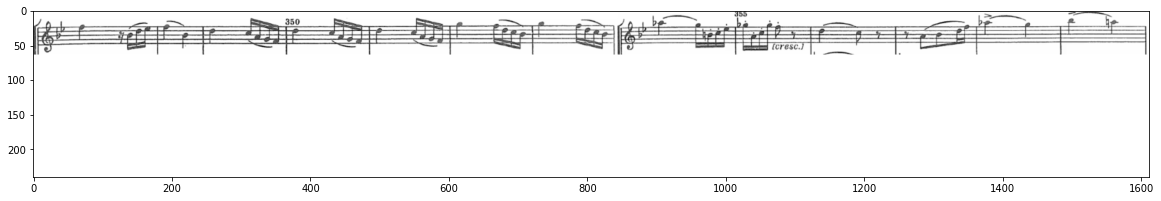

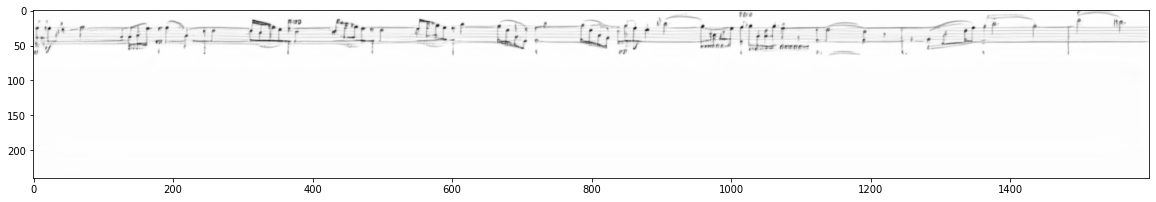

tensor([12666, 13227,  4366,  2514,  6863,  4756,  3750,  3385,   859,  7883,
        10687,   247, 12882,  7585,   953,  2999,    59,  3750,  1955,  1080,
         9796,  4753,   744,  5754,  7690,  5889,  1335, 11364,  7636,   867,
         1521,   624,  2611,  3005,  8432,  8658,  7672,  1825, 12789,  2209,
         2807,  1474, 14186,  7048,   643,  6770,  9369,  5673,  1270, 14000,
        12633,  2113,  1636, 13941,  6113, 11259, 11017, 13951, 13126, 13770,
         6874,  2043,   535,   586,  5132,  2677, 12421, 11191,  2106,  3486,
         2611,  4336, 10953, 10029,  2425,  2388,  3385,  2999,  4483,  2635,
          782,   839, 10693, 11255,  4249, 11826, 12874, 13570, 13822, 11345,
         4504,  2368,  4998,  4085, 12843,  1537,  4261,  9952,  5659,  3279],
       device='cuda:0')


[:,-192:]


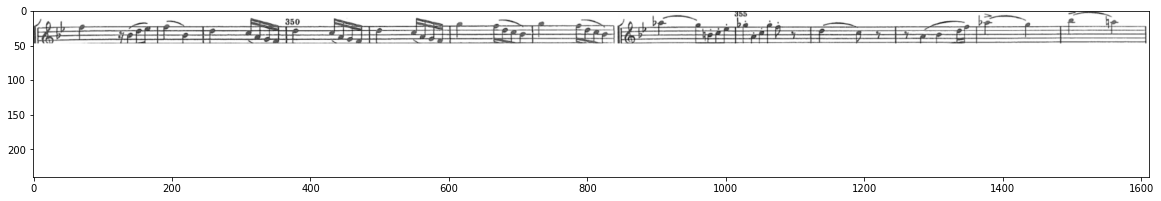

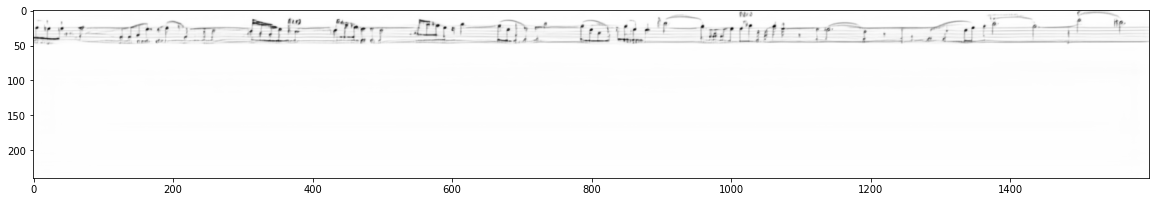

tensor([12082, 13227, 10620,  2514,  6144,  4756,  3750,  3385,   602,  8762,
        11725,   247, 12882,  7585,  5343,  1974,    59,  4143,  1955,  5476,
         9796,  1996,  3610,  9020,   769,  5889,  3666, 11364,  7048,    59,
         1521,  3320,  2611,  3753, 10471,  8673,  7672,  1825, 12789,  3405,
         2807,  5489, 14186,  8852,   643,  2996,  9369,  5673,  1270, 13967,
        12633,  2113,   544, 13941,  6113, 11259, 11569, 13951, 13525, 13475,
         6874,  2043,   535,   586,  5132,  1246, 12421, 10530,  2106,  2530,
         1974,  1020, 10953, 11417,  2312,  2194,  4382,  2999,  4483,  4015,
          782,  1811, 10693, 12175,  5722, 11790, 11771, 13570, 13822, 11345,
         5407,  2368,  7028,  4085, 12886,  1537,  5506,  9952,  5977,  3666],
       device='cuda:0')


[:,-208:]


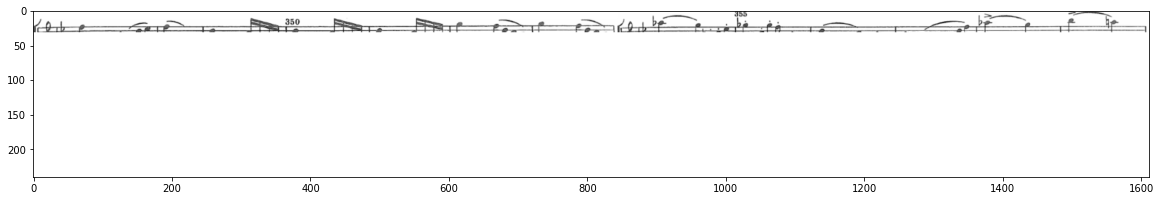

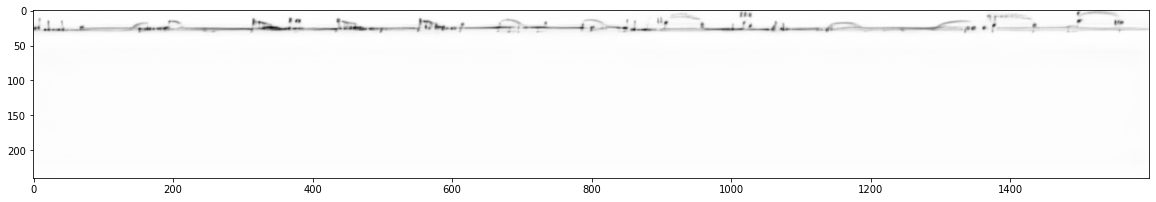

tensor([12503, 13078,  9969,  1081,  6661,  3143,  3143,  4090,  2457, 10372,
        10415,  1862, 13065,  8109,  2194,  3486,  3143,  4143,  5065,  7629,
         9741,  4446,   537, 10117,  8883,  1521,  3951, 12411,  8613,  3385,
         5981,  3385,  4143,  6099, 10263,  9970,  9275,  5889, 12296,  3644,
         3263,  2106, 14220, 10212,  1752,  3047, 10572,  2388,  1636, 13732,
        12633,  4595,  7941, 13928,  4891, 11964, 12371, 14067, 13126, 13170,
         7304,  1521,  6770,  2698, 12098,  7515, 12421, 10655,  2388,  4143,
         2484,  2368, 11842, 11477,  1962,  3223,  4143,  4143,  3223,  3503,
         1862,  1962, 12690, 12293,  5722, 10781, 11974, 13429, 13951, 12398,
         6193,  3143,   624,  6568, 13782,  2216,  6778,  8142,  4987,  2530],
       device='cuda:0')


[:,-224:]


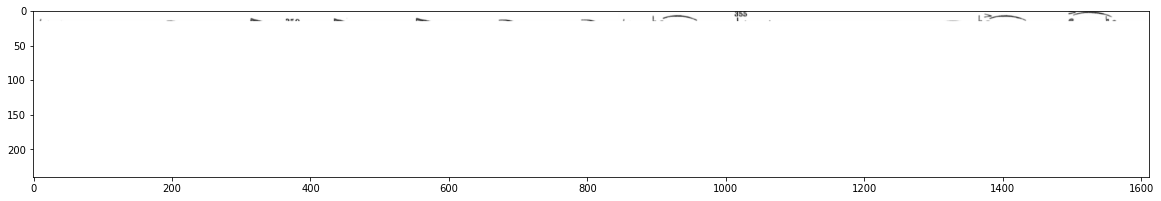

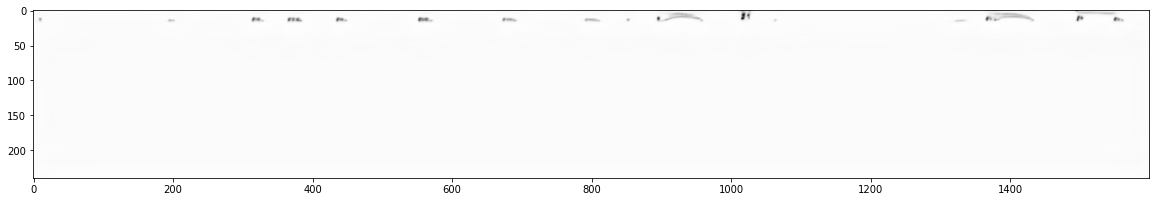

tensor([12793, 11006, 11355, 10655, 10655, 10655, 10655, 10655, 10655, 10655,
        11355,  9903, 11411, 10655, 11355, 10655, 10655, 10272,  8654, 13754,
         6373,  8232, 12228,  7246, 10329,  6873,  7822,  8319, 10586,  8654,
        10655, 10655, 10272,  8124, 14084,  5508,  9437, 10103, 10655, 10655,
        10103,  7772, 10996, 10464,  8124, 10655, 10655, 11355,  8786, 13374,
         8673,  8820,  7071, 12570,  8232,  8879, 12371, 13213, 13161, 11493,
         9154,  7755,  4743,   380, 11103,  5659, 13544, 10655, 11355, 11355,
        11355, 11355, 11355, 11355, 11355, 11355, 11355, 11355, 11355, 11355,
        11355, 10103, 12801, 10893,  5414, 13472, 12681, 13906, 13762,  9016,
         7894,  9903,  6162,  9571, 14132,  3453, 10855,  5508,  8557, 10103],
       device='cuda:0')




In [25]:
for i in range(0,img.shape[-2]//16):
  print(f"[:,{- i * 16}:]")
  img_copy = img.clone()
  img_copy[:,img_copy.shape[-2] - i * 16:] = 1
  quant, emb_loss, info = model.encode(img_copy.unsqueeze(0).cuda())
  flattend_out = info[2].view(quant.shape[0],quant.shape[-2],quant.shape[-1])
  decoded = model.decode_code(flattend_out)
  plt.figure(figsize=(20,10), dpi=72)
  imshow(img_copy.squeeze().cpu())
  plt.figure(figsize=(20,10), dpi=72)
  imshow(decoded.squeeze().cpu())
  print(flattend_out[0,0])
  print("\n")